# Task 2 - Stopping to pay premium

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fsolve

### Task 2.1 - Premium of the product at inception

#### Calculation via commutation numbers

In [53]:
# Parameters according to the task description
x = 80
n = 10
it = 0.02
i = 0.04
L = 100000
omega = 120

v = 1/(1+it)

def Qx(x, gender=0, t=2020):
    # This is our default mortality
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def l(x):
    px = 1
    for i in range(x):
        px *= (1-Qx(i))
    return px

def D(x):
    return l(x)*v**x

def N(x):
    N = 0
    for i in range(x, omega):
        N += D(i)
    return N

def S(x):
    S = 0
    for i in range(x, omega):
        S += N(i)
    return S

def C(x):
    return (l(x)-l(x+1))*v**(x+1)

def M(x):
    M = 0
    for i in range(x, omega):
        M += C(i)
    return M

def R(x):
    R = 0
    for i in range(x, omega):
        R += M(i)
    return R

A_xn = (M(x)-M(x+n)+D(x+n))/D(x)
a_xn = (N(x)-N(x+n))/D(x)
Pi = L*A_xn/a_xn
print("The premium calculated using commutation numbers is: ", round(Pi,2))

The premium calculated using commutation numbers is:  12302.98


#### Calculation using the Markov model

In [54]:
# Parameters according to the task description
x = 80
n = 10
it = 0.02
i = 0.04
L = 100000

def Qx(x, gender=0, t=2020):
    # This is our default mortality
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def Pxt(x, t):
    Pxt = 1
    for i in range(x, t):
        Pxt *= 1-Qx(i)
    return Pxt
    
def premium(t, P, x=x, n=n, i=it):
    if t>=x and t<x+n:
        return -Pxt(x, t)*P/(1+i)**(t-x)
    else: return 0

def death_benefit(t, L=L, x=x, n=n, i=it):
    if t>x and t<=x+n:
        return Pxt(x, t-1)*Qx(t-1)*L/(1+i)**(t-x)
    else: return 0

def life_benefit(t, L=L, x=x, n=n, i=it):
    if t==x+n:
        return Pxt(x, t)*L/(1+i)**(t-x)
    else: return 0

def total(P, L=L, lrange=x, hrange=x+n+1):
    return sum([premium(t, P) + death_benefit(t, L) + life_benefit(t, L) for t in range(lrange, hrange)])


The premium determined by means of the equivalence principle is: 12302.98


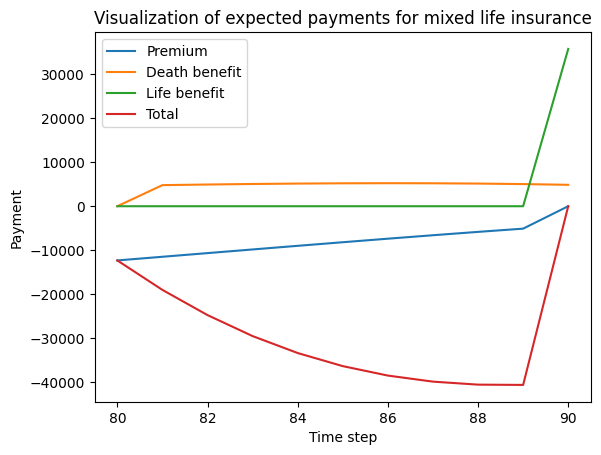

In [56]:
t_range = np.arange(x, x+n+1)
P = fsolve(total, 20000)[0]
print('The premium determined by means of the equivalence principle is:', round(P, 2))

plt.plot(t_range, [premium(t, P) for t in t_range], label='Premium')
plt.plot(t_range, [death_benefit(t) for t in t_range], label='Death benefit')
plt.plot(t_range, [life_benefit(t) for t in t_range], label='Life benefit')
plt.plot(t_range, [total(P, hrange=t) for t in t_range+1], label='Total')
plt.title('Visualization of expected payments for mixed life insurance')
plt.xlabel('Time step')
plt.ylabel('Payment')
plt.legend()
plt.show()

### Task 2.2 - Benefit if the policyholder stops paying after one premium

#### Calculation using commutation numbers

In [67]:
def reduced_benefit(p):
    A_xp_np = (M(x+p)-M(x+n)+D(x+n))/D(x+p)
    Vx_p = L*A_xp_np-P*(N(x+p)-N(x+n))/D(x+p)
    return Vx_p/A_xp_np

print("The modified benefit calculated using commutation numbers is: ", round(reduced_benefit(1),2))

The modified benefit calculated using commutation numbers is:  9228.77


#### Calculation using the Markov model

In [58]:
def premium(t, P, num_prems_paid=None, x=x, n=n, i=it):
    if t>=x and t<x+n and (num_prems_paid is None or t<x+num_prems_paid):
        return -Pxt(x, t)*P/(1+i)**(t-x)
    else: return 0

def death_benefit(t, L=L, num_prems_paid=None, L_prime=0, x=x, n=n, i=it):
    if t>x and t<=x+n and (num_prems_paid is None or t<=x+num_prems_paid):
        return Pxt(x, t-1)*Qx(t-1)*L/(1+i)**(t-x)
    elif t>x and t<=x+n:
        return Pxt(x, t-1)*Qx(t-1)*L_prime/(1+i)**(t-x)
    else: return 0

def life_benefit(t, L=L, num_prems_paid=None, L_prime=0, x=x, n=n, i=it):
    if t==x+n and num_prems_paid is None:
        return Pxt(x, t)*L/(1+i)**(t-x)
    elif t==x+n:
        return Pxt(x, t)*L_prime/(1+i)**(t-x)
    else: return 0

def total_one_premium(L_prime, P=P, L=L, num_prems_paid=1, lrange=x, hrange=x+n+1):
    return sum([premium(t, P, num_prems_paid) + death_benefit(t, L, num_prems_paid, L_prime) + life_benefit(t, L, num_prems_paid, L_prime) for t in range(lrange, hrange)])


The benefit determined by means of the equivalence principle if the policyholder stops paying after one premium is: 9228.77


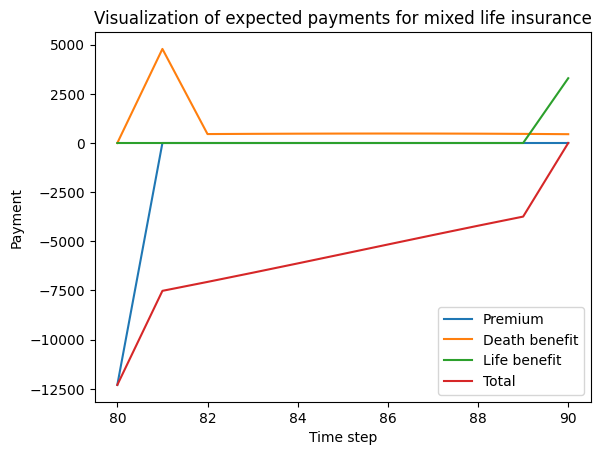

In [59]:
t = np.arange(x, x+n+1)
L_prime = fsolve(total_one_premium, 20000)[0]
print('The benefit determined by means of the equivalence principle if the policyholder stops paying after one premium is:', round(L_prime, 2))

plt.plot(t, [premium(t, P, 1) for t in range(x, x+n+1)], label='Premium')
plt.plot(t, [death_benefit(t, L, 1, L_prime) for t in range(x, x+n+1)], label='Death benefit')
plt.plot(t, [life_benefit(t, L, 1, L_prime) for t in range(x, x+n+1)], label='Life benefit')
plt.plot(t, [total_one_premium(L_prime, hrange=t) for t in range(x+1, x+n+2)], label='Total')
plt.title('Visualization of expected payments for mixed life insurance')
plt.xlabel('Time step')
plt.ylabel('Payment')
plt.legend()
plt.show()

### Task 2.3 - Benefit level as a function of the number of premiums paid

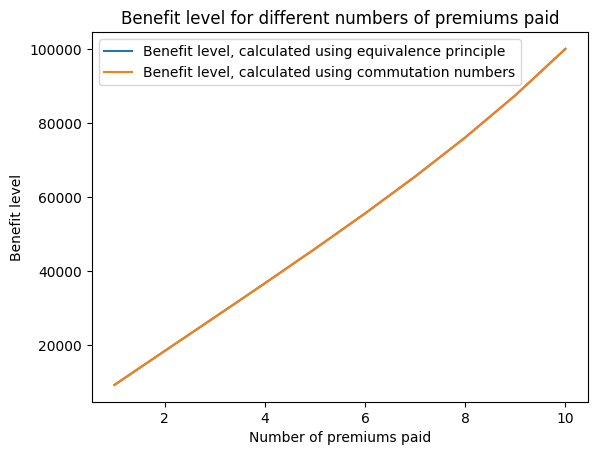

In [66]:
num_prems_paid = np.arange(1, n+1)
benefit_level = [fsolve(total_one_premium, 20000, args=(P, L, num_prems_paid[i]))[0] for i in range(n)]
plt.plot(num_prems_paid, benefit_level, label='Benefit level, calculated using equivalence principle')
plt.plot(num_prems_paid, [reduced_benefit(p) for p in num_prems_paid], label='Benefit level, calculated using commutation numbers')
plt.legend()
plt.title('Benefit level for different numbers of premiums paid')
plt.xlabel('Number of premiums paid')
plt.ylabel('Benefit level')
plt.show()